# Hyperparameter Tuning with the HParams Dashboard

In [1]:
# Import TensorFlow and the TensorBoard HParams plugin:

import tensorflow as tf
import tensorboard as tb
from tensorboard.plugins.hparams import api as hp

print("The version of Tensorflow: {}".format(tf.__version__))
print("The version of Tensorboard: {}".format(tb.__version__))

The version of Tensorflow: 2.4.1
The version of Tensorboard: 2.4.1


In [2]:
# Download the FashionMNIST dataset and scale it:

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## 1. Experiment setup and the HParams experiment summary

In [3]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

## 2. Adapt TensorFlow runs to log hyperparameters and metrics

In [4]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(x_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [5]:
# For each run, log an hparams summary with the hyperparameters and final accuracy:

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

## 3. Start runs and log them all under one parent directory

In [6]:
# Run a few experiments, which will take a few minutes:

session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
313/313 [==============================] - 1s 1ms/step - loss: 0.4797 - accuracy: 0.8321
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
313/313 [==============================] - 1s 1ms/step - loss: 0.6814 - accuracy: 0.7646
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
313/313 [==============================] - 1s 1ms/step - loss: 0.5045 - accuracy: 0.8195
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'sgd'}
313/313 [==============================] - 1s 1ms/step - loss: 0.7112 - accuracy: 0.7609
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
313/313 [==============================] - 1s 1ms/step - loss: 0.4633 - accuracy: 0.8336
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
313/313 [==============================] - 1s 1ms/step - loss: 0.6032 - 

## 4. Visualize the results in TensorBoard's HParams plugin

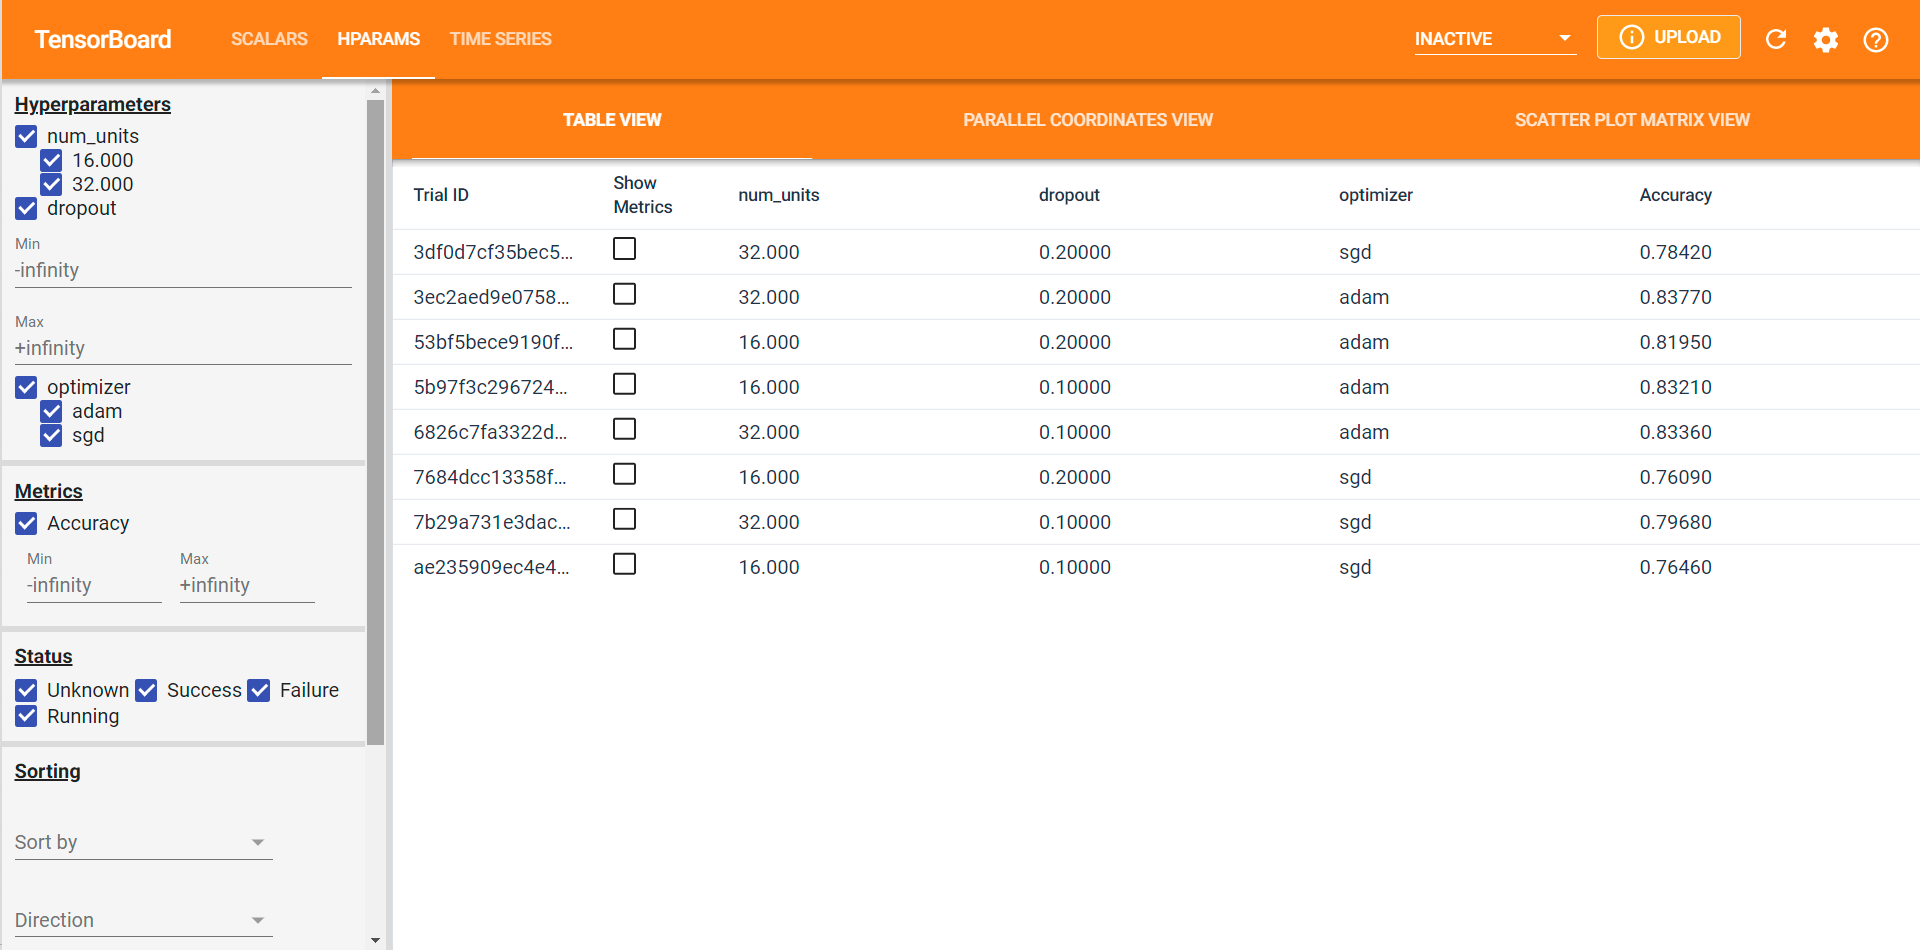

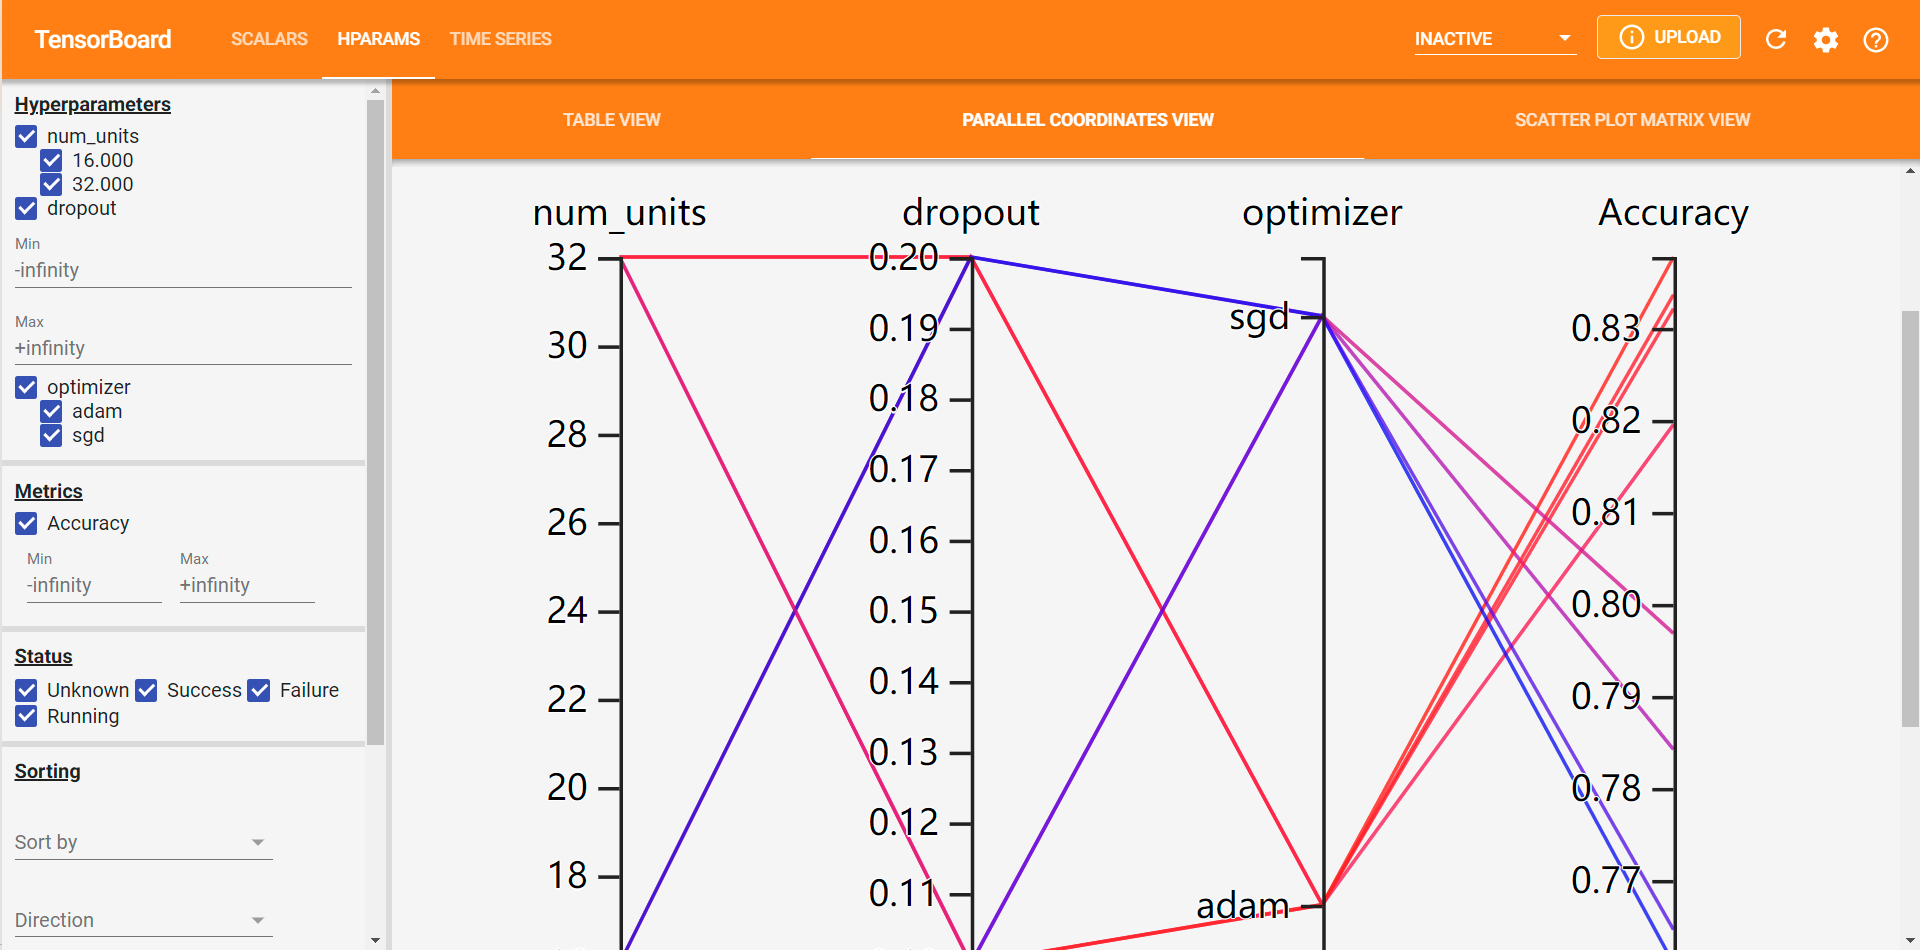

In [8]:
from IPython.display import Image, display
display(Image(filename="./image/hyperparams.png", embed=True))
display(Image(filename="./image/hyperparams2.png", embed=True))

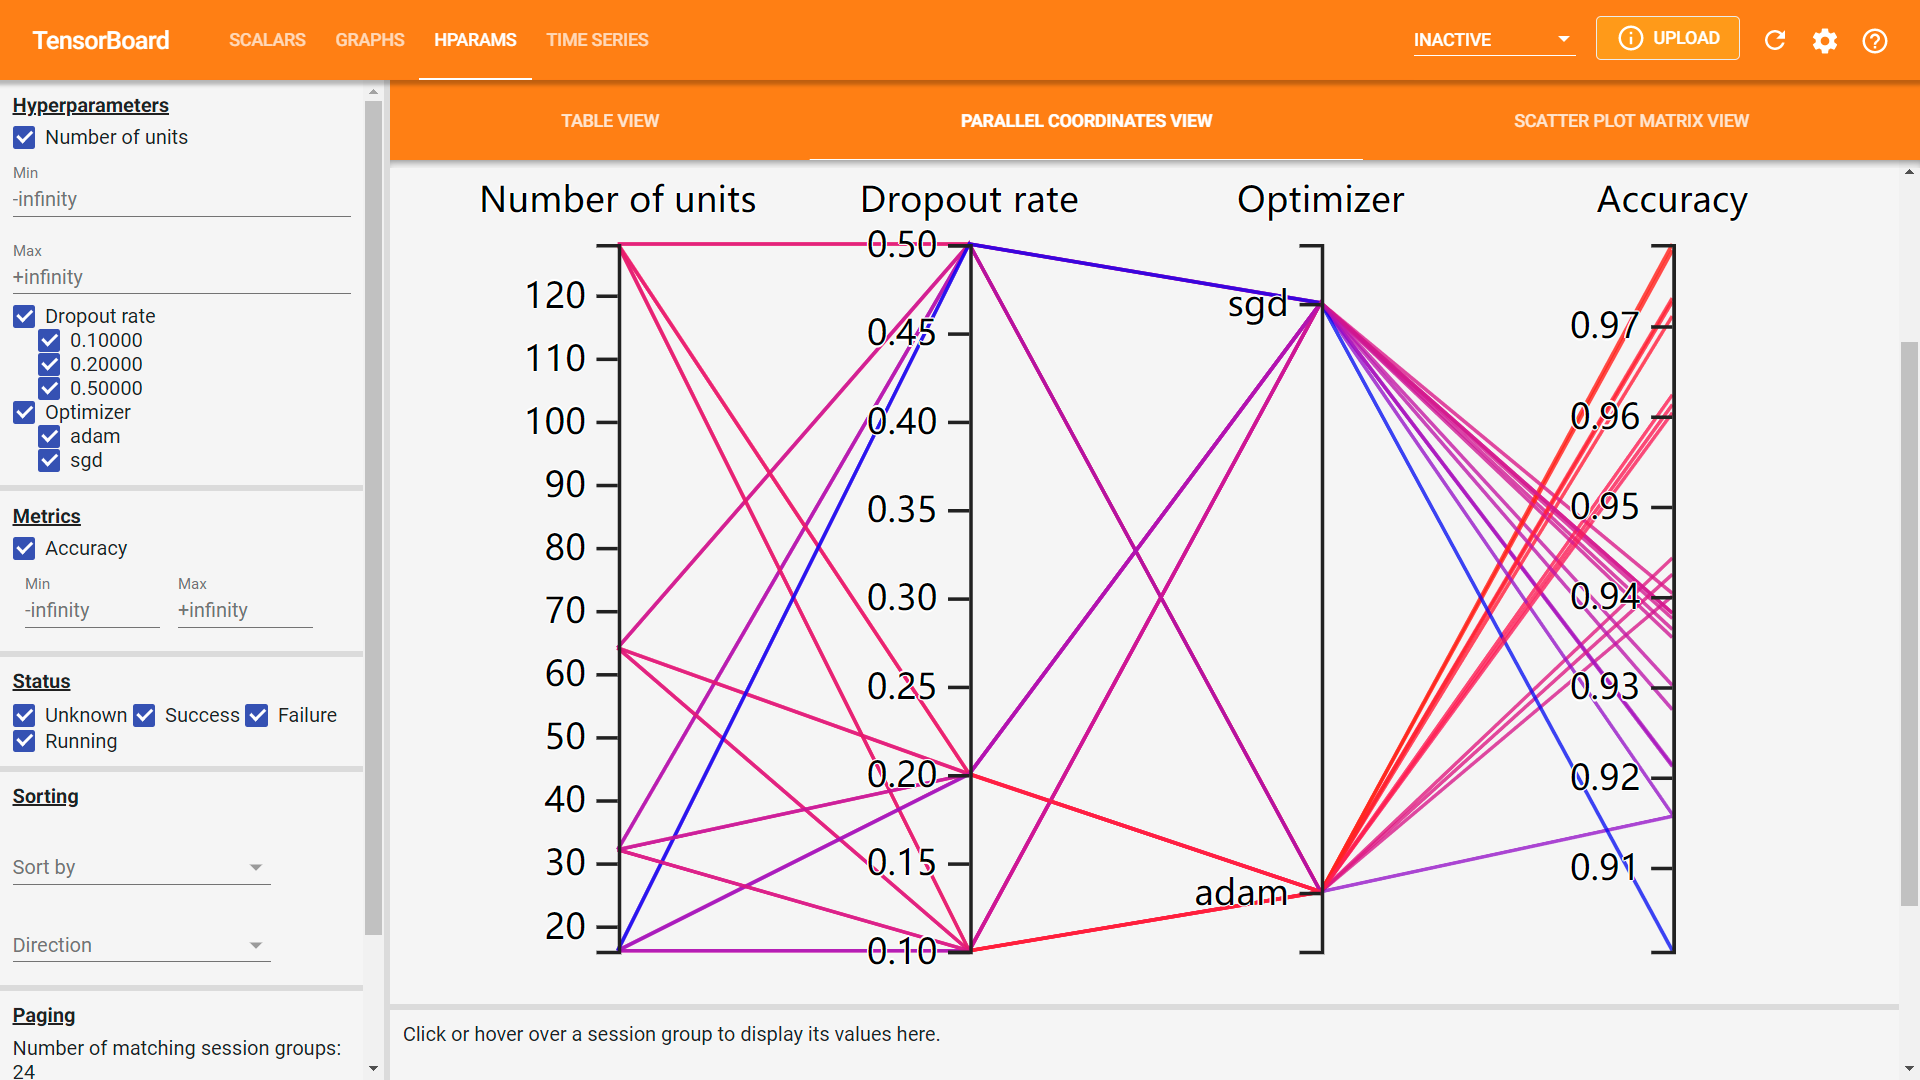

In [9]:
from IPython.display import Image, display
display(Image(filename="./image/hyperparams3.png", embed=True))

# reference

### https://tensorflow.google.cn/tensorboard/hyperparameter_tuning_with_hparams